In [0]:
# Import the necessary libraries

import os
import numpy as np
from keras import layers
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.optimizers import SGD, Adam

In [21]:
# Load the cifar-10 dataset and store the training and testing images in X_train, Y_train and X_text, Y_test

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("Train Set Size = {} images".format(X_train.shape[0]))
print("Test Set Size = {} images".format(X_test.shape[0]))

Train Set Size = 50000 images
Test Set Size = 10000 images


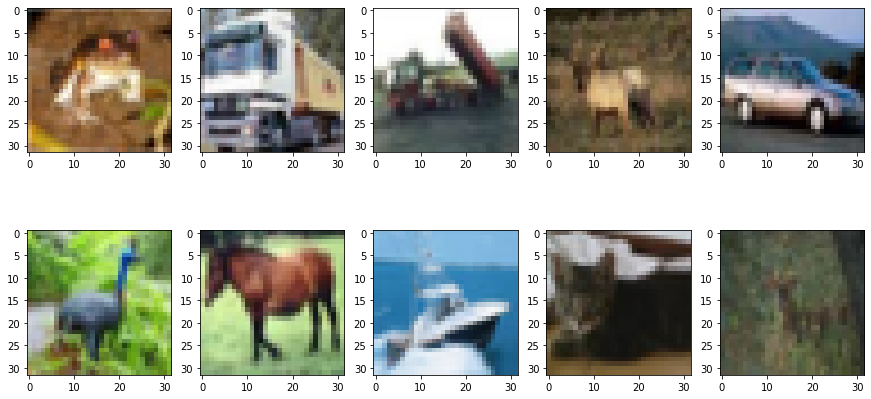

Labels : [[6]
 [9]
 [9]
 [4]
 [1]]
Labels : [[2]
 [7]
 [8]
 [3]
 [4]]


In [22]:
# Display few images from training sample

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(X_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(X_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

**The label data is just a list of 10,000 numbers ranging from 0 to 9, which corresponds to each of the 10 classes in CIFAR-10.**

airplane : 0, automobile : 1, bird : 2, cat : 3, deer : 4, dog : 5, frog : 6, horse : 7, ship : 8, truck : 9

In [0]:
# Data Preprocessing

# convert to categorical
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10) 

# float and normalization
X_train = X_train.astype('float32'); X_test = X_test.astype('float32');
X_train /= 255; X_test /= 255;

In [0]:
# Configure RestNet and its model parameters

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
objective = 'categorical_crossentropy'

def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def resNet():
    
    # Define the input as a tensor with shape input_shape
    X_input = Input((32,32,3))
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # AVGPOOL
    # X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(Y_train.shape[1], activation='softmax', name='fc' + str(Y_train.shape[1]))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    #Compile the model
    model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
    return model

In [0]:
# Store the defined model in a variable

model = resNet()

In [26]:
# Summary of built ResNet model
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
# Configure training parameters

nb_epoch = 50
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_resNet():
    
    history = LossHistory()
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(X_test, verbose=0)
    return predictions, history

def test_accuracy():
    tp = []
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
            tp.append(i)
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err, tp

In [28]:
# Train the RestNet model

predictions, history = run_resNet()

Train on 37500 samples, validate on 12500 samples
Epoch 1/50
37500/37500 [==============================] - 109s 3ms/step - loss: 2.1417 - accuracy: 0.3469 - val_loss: 2.4233 - val_accuracy: 0.1819
Epoch 2/50
37500/37500 [==============================] - 96s 3ms/step - loss: 2.1461 - accuracy: 0.3398 - val_loss: 9.5876 - val_accuracy: 0.3291
Epoch 3/50
37500/37500 [==============================] - 96s 3ms/step - loss: 1.9796 - accuracy: 0.3746 - val_loss: 192.6929 - val_accuracy: 0.1574
Epoch 4/50
37500/37500 [==============================] - 96s 3ms/step - loss: 1.9137 - accuracy: 0.3756 - val_loss: 2.0766 - val_accuracy: 0.4412
Epoch 5/50
37500/37500 [==============================] - 96s 3ms/step - loss: 1.7626 - accuracy: 0.4300 - val_loss: 2.6499 - val_accuracy: 0.2346
Epoch 6/50
37500/37500 [==============================] - 97s 3ms/step - loss: 1.7308 - accuracy: 0.4397 - val_loss: 1.6394 - val_accuracy: 0.4326
Epoch 7/50
37500/37500 [==============================] - 97s 3ms

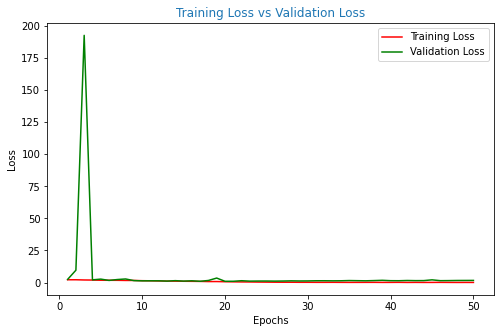

In [39]:
# Check the Training loss and Validation loss over epoch size
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Training Loss vs Validation Loss', color='C0')
ax.set(xlabel='Epochs', ylabel='Loss')
ax.plot(range(1,nb_epoch+1),history.losses,  label='Training Loss',color='red')
ax.plot(range(1,nb_epoch+1),history.val_losses, label='Validation Loss', color='green')
ax.legend()

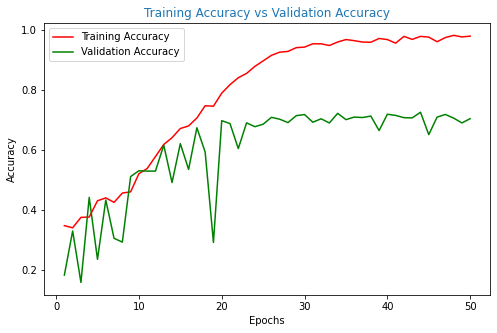

In [30]:
# Check the Training Accuracy and Validation Accuracy over epoch size
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Training Accuracy vs Validation Accuracy', color='C0')
ax.set(xlabel='Epochs', ylabel='Accuracy')
ax.plot(range(1,nb_epoch+1),history.acc,  label='Training Accuracy',color='red')
ax.plot(range(1,nb_epoch+1),history.val_acc, label='Validation Accuracy', color='green')
ax.legend()

In [31]:
# Evaluate the Test Accuracy
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 70.0 %


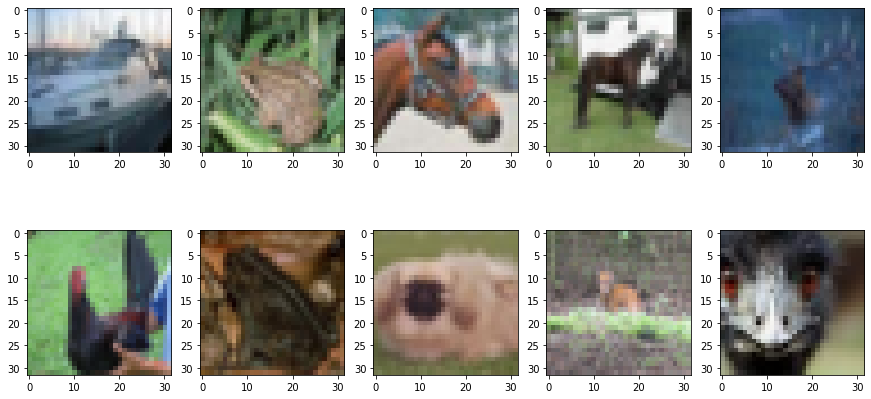

True:          [[8]
 [6]
 [7]
 [7]
 [4]]
classified as: [0 4 9 2 0]
True:          [[2]
 [6]
 [5]
 [4]
 [2]]
classified as: [4 3 4 7 1]


In [32]:
# Visualize few incorrectly classified test samples

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(X_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(X_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))

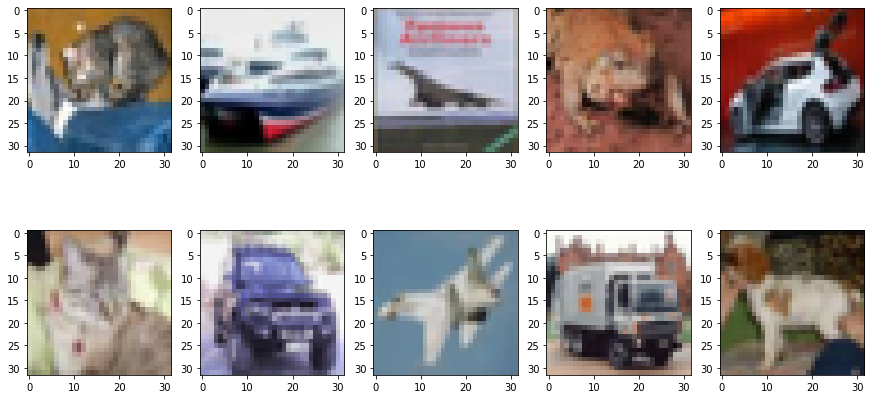

True:          [[3]
 [8]
 [0]
 [6]
 [1]]
classified as: [3 8 0 6 1]
True:          [[3]
 [1]
 [0]
 [9]
 [5]]
classified as: [3 1 0 9 5]


In [33]:
# Visualize few correctly classified test samples

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(X_test[p[3][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(X_test[p[3][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[3][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[3][0:5]], axis=1)))

print("True:          {}".format(y_test[p[3][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[3][6:11]], axis=1)))